# Creating a simple Bayesian model
Using the data from following table create a model predicting number of passenger deaths. Use poisson distribution in two variants

The rate is constant for all years and not depending on anything.
The intensity is constant, but rate is a product of intensity and miles flown.
Select appropriate priors, perform prior predictive checks, fit the model and using posterior predictive distribution predict the death rates from the model.

In [1]:
# enviroment conda to start: DataAnalytics
# command: conda activate DataAnalytics

import sys
import pystan
sys.path.append("D:\Pawel\DA\Lab4")
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


# 1. The rate is constant for all years and not depending on anything.

- I defined prior probability (normal distribution), where 96% values are between range 223 (1984) - 1066 (1985) ( we need to start from something)

In [3]:
name_1 = "prior_1.stan"

with open(name_1, 'r') as file:
    print(file.read())
air_tun = stan_utility.compile_model(name_1)

functions {
  vector tail_delta(vector y,       //unknowns
                    vector theta,   //parameters
                    real[] x_r,     // data(real)
                    int[] x_i) {    //data(integer)
    vector[2] deltas;

    deltas[1] = normal_cdf(theta[1], y[1], y[2]) - 0.95; //5% that more than 1066 deaths
    deltas[2] = normal_cdf(theta[2], y[1], y[2]) - 0.05; //5% that less than 223 deaths
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of Gaussian standard deviation
  vector<lower=0>[2] theta;   // Target quantile
}

transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Find gamma parameters that ensures 90% probabilty from 223 to 1066
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
  print("mu  = ", y[1]);
  print("sigma = ", y[2]);
}

generated quantities {
  real mu = y[1];
  real sigma = y[2];
}
Using cached StanModel


In [4]:
# show the data
Airline_data.head()

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0


In [5]:
# data=dict(y=np.array([670,200]),theta=np.array([1066,223]))

# air_tuned = air_tun.sampling(data=data, seed=1050000, algorithm="Fixed_param", iter=1, chains=1)
air_tuned = air_tun.sampling(data=dict(y_guess=np.array([670,200]),theta=np.array([1066,223])),
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
mu = np.round(air_tuned.extract()['mu'][0])
sigma = np.round(air_tuned.extract()['sigma'][0])

print(f"mu: {mu}, Sigma: {sigma}")

mu: 644.0, Sigma: 256.0


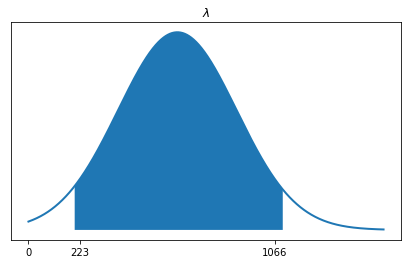

In [6]:
fig, ax2 = plt.subplots(1, 1, figsize=(7, 4))
x2=np.linspace(0,6*sigma,1000)
x4=np.linspace(200,1100,1000)
ax2.plot(x2,stats.norm.pdf(x2,loc=mu,scale=sigma),linewidth=2)
ax2.fill_between(x4,stats.norm.pdf(x4,loc=mu,scale=sigma),0)
ax2.set_yticks([])
ax2.set_xticks([0,223,1066])
ax2.set_title(r'$\lambda$')
plt.show()

In [7]:
# Prior predictive distribution

name_2 = "prior_2.stan"

with open(name_2, 'r') as file:
    print(file.read())
    
model_pr_pre_d=stan_utility.compile_model(name_2)

data 
{
//number of years
  int M;
}

generated quantities 
{
  real lambda=normal_rng(650,274);
  
  int y_sim[M];
  
  for (k in 1:M) 
  {
    y_sim[k] = poisson_rng(lambda);
  }
}

Using cached StanModel


In [8]:
R=1000
sim_uf=model_pr_pre_d.sampling(data={'M':1},
                               algorithm="Fixed_param",
                               iter=R,
                               warmup=0,
                               chains=1, 
                               refresh=R,
                               seed=29042020)

C:\Users\kflud\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kflud\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\kflud\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kflud\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


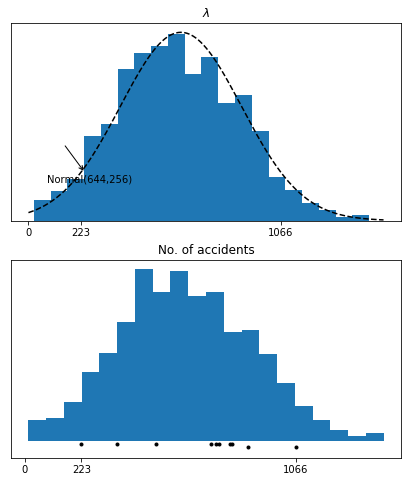

In [9]:
params=sim_uf.extract()
theta=params['lambda']
y_sim=params['y_sim']

fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,1500,2000)
ax1.set_xticks([0,223,1066])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,stats.norm.pdf(x,mu,sigma),color='black',linestyle='--')
arr_y_loc = stats.norm.pdf(300,mu,sigma)
ax1.annotate('Normal('+str(np.int(mu))+','+str(np.int(sigma))+')',xy=(150,arr_y_loc),xytext=(80,0.5*arr_y_loc),arrowprops={'arrowstyle':'<-'})
ax2=axes[1]
ax2.hist(y_sim.flatten(), density=True,bins=20,zorder=1)
ax2.scatter(c2,0.00003*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,223,1066])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

# not accurate, but well made if we consider that there was lack of info

In [10]:
# Posterior inference and posterior predictive checks
name_3 = "prior_3.stan"

with open(name_3, 'r') as file:
    print(file.read())
    
model_3=stan_utility.compile_model(name_3)

data 
{
  //number of years analyzed
  int M;
  
  //number of deaths
  int Y[M];
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(644,256);
  for (k in 1:M) {
    Y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}

Using cached StanModel


In [11]:
data = dict(M = len(Airline_data),
            Y = Airline_data['Passenger deaths'])
model_3_fit = model_3.sampling(data=data, seed=8052020)

params=model_3_fit.extract()
lam=params['lambda']
y_sim=params['y_sim']


# calculate mean
mean_lam = np.mean(lam)
# Calculate highest posterior density (HPD) of array for given credible_interval.
cinf_lam = az.hpd(lam, 0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

print(f"Outputs:\n\t- Mean lamda: {mean_lam}, \n\t- 89% confidence interval: {(cinf_lam.__str__())}")

Outputs:
	- Mean lamda: 691.7231305610321, 
	- 89% confidence interval: [677.10476718 708.45238303]


C:\Users\kflud\anaconda3\lib\site-packages\arviz\stats\stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


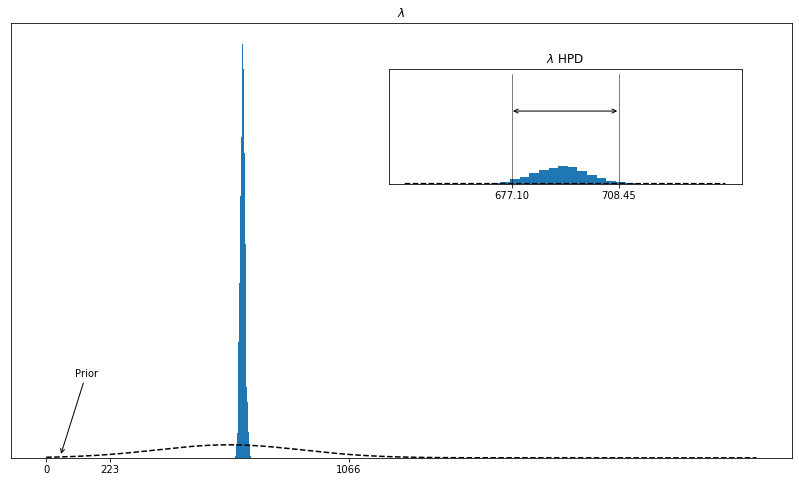

In [12]:
fig, ax1 = plt.subplots(1, 1,figsize=(14, 8))

ax1.hist(lam,bins=20,density=True)
x=np.linspace(0,2500,10000)
#ax1.plot(x,2*stats.t.pdf(x,5,0,10),color='black',linestyle='--')

ax1.plot(x,stats.norm.pdf(x,mu,sigma),color='black',linestyle='--')
arr_y_loc = stats.norm.pdf(150,mu,sigma)
ax1.annotate('Prior',xy=(50,arr_y_loc),xytext=(100,40*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,223,1066])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam,bins=20,density=True)
ax_sm.plot(x_sm,stats.norm.pdf(x_sm,mu,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(cinf_lam[0]-.2,0.2), xytext=(cinf_lam[1]+.2,0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.3],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.3],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')

plt.show()

In [13]:
# Using created model for prediction

median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.89)

print('Median of predicted accidents =',median_y_sim)
print('Confidence interval = [', *cinf_y_sim,']')

Median of predicted accidents = 691.0
Confidence interval = [ 637.0 741.0 ]


C:\Users\kflud\anaconda3\lib\site-packages\arviz\stats\stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
